In [ ]:
#all_slow

# Tutorial&#58; Fine-Tuning Sequence Classification on HuggingFace `Datasets` with MRPC
> Tuning a Sequence Classification model on the Microsoft MRPC dataset

## Introduction

In this tutorial we will be showing an end-to-end example of fine-tuning a Transformer for sequence classification on a custom dataset in HuggingFace `Dataset` format.

By the end of this you should be able to:

1. Build a dataset with the `TaskDatasets` class, and their DataLoaders
2. Build a `SequenceClassificationTuner` quickly, find a good learning rate, and train with the One-Cycle Policy
3. Save that model away, to be used with deployment or other HuggingFace libraries
4. Apply inference using both the `Tuner` available function as well as with the `EasySequenceClassifier` class within AdaptNLP

## Installing the Library

This tutorial utilizies the latest AdaptNLP version, as well as parts of the `fastai` library. Please run the below code to install them:

```python
!pip install adaptnlp -U
```
(or `pip3`)

In [ ]:
#hide
from nbverbose.showdoc import *

## Getting the Dataset

First we need a dataset. We will use `dataset`'s `load_dataset` function to quickly generate a raw dataset straight from HuggingFace:

In [ ]:
from datasets import load_dataset

In [ ]:
raw_datasets = load_dataset("glue", "mrpc")

Reusing dataset glue (/root/.cache/huggingface/datasets/glue/mrpc/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


We now have a raw `datasets` dataset, which we can index into:

In [ ]:
raw_datasets['train'][0]

{'idx': 0,
 'label': 1,
 'sentence1': 'Amrozi accused his brother , whom he called " the witness " , of deliberately distorting his evidence .',
 'sentence2': 'Referring to him as only " the witness " , Amrozi accused his brother of deliberately distorting his evidence .'}

Now that we have the data downloaded, let's decide on a model to use.

## Picking a Model with the Hub

AdaptNLP has a `HFModelHub` class that allows you to communicate with the HuggingFace Hub and pick a model from it, as well as a namespace `HF_TASKS` class with a list of valid tasks we can search by.

Let's try and find one suitable for sequence classification.

First we need to import the class and generate an instance of it:

In [ ]:
from adaptnlp import HFModelHub, HF_TASKS

In [ ]:
hub = HFModelHub()

Next we can search for a model:

In [ ]:
models = hub.search_model_by_task(HF_TASKS.TEXT_CLASSIFICATION)

Let's look at a few:

In [ ]:
models[:10]

[Model Name: distilbert-base-uncased-finetuned-sst-2-english, Tasks: [text-classification],
 Model Name: roberta-base-openai-detector, Tasks: [text-classification],
 Model Name: roberta-large-mnli, Tasks: [text-classification],
 Model Name: roberta-large-openai-detector, Tasks: [text-classification]]

These are models specifically tagged with the `text-classification` tag, so you may not see a few models you would expect such as `bert_base_cased`.

Let's search for that one for this problem:

In [ ]:
models = hub.search_model_by_name('bert-base-uncased', user_uploaded=True)

In [ ]:
models[:5]

[Model Name: bert-base-uncased, Tasks: [fill-mask],
 Model Name: distilbert-base-uncased-distilled-squad, Tasks: [question-answering],
 Model Name: distilbert-base-uncased-finetuned-sst-2-english, Tasks: [text-classification],
 Model Name: distilbert-base-uncased, Tasks: [fill-mask],
 Model Name: 123abhiALFLKFO/distilbert-base-uncased-finetuned-cola, Tasks: [text-classification]]

We want the first one.

In [ ]:
model = models[0]

Now that we have picked a model, let's use the data API to prepare our data

> Note: It should be mentioned that this is optional, you can always just pass in the string name of a model such as "bert-base-cased"

## Building `TaskDatasets`

All of the task-specific high-level data API's (such as `SequenceClassificationDatasets`) all wrap around the `TaskDatasets` class, which is a small wrapper around `datasets` highly efficient `Dataset` class.

This integration was valuable because it provides a fast and memory-efficient way to use large datasets with minimal effort. 

First let's import the class:

In [ ]:
from adaptnlp import TaskDatasets

The `TaskDatasets` class has no class constructors outside the normal one. The reason for this is it takes in raw `Datasets` and other tokenizer arguments to build from:

In [ ]:
from adaptnlp import TaskDatasets
show_doc(TaskDatasets)

<h2 id="TaskDatasets" class="doc_header"><code>class</code> <code>TaskDatasets</code><a href="https://github.com/novetta/adaptnlp/tree/master/adaptnlp/training/core.py#L168" class="source_link" style="float:right">[source]</a></h2>

> <code>TaskDatasets</code>(**`train_dset`**, **`valid_dset`**, **`tokenizer_name`**:`str`=*`None`*, **`tokenize`**:`bool`=*`True`*, **`tokenize_func`**:`callable`=*`None`*, **`tokenize_kwargs`**:`dict`=*`{}`*, **`auto_kwargs`**:`dict`=*`{}`*, **`remove_cols`**:`Union`\[`str`, `List`\[`str`\]\]=*`None`*)

A set of datasets for a particular task, with a simple API.

Note: This is the base API, `items` should be a set of regular text and model-ready labels,
      including label or one-hot encoding being applied.

**Parameters:**


 - **`train_dset`** : *`<class 'inspect._empty'>`*	<p>A train `Dataset` object</p>


 - **`valid_dset`** : *`<class 'inspect._empty'>`*	<p>A validation `Dataset` object</p>


 - **`tokenizer_name`** : *`<class 'str'>`*, *optional*	<p>The string name of a `HuggingFace` tokenizer or model. If `None`, will not tokenize the dataset.</p>


 - **`tokenize`** : *`<class 'bool'>`*, *optional*	<p>Whether to tokenize the dataset immediatly</p>


 - **`tokenize_func`** : *`<built-in function callable>`*, *optional*	<p>A function to tokenize an item with</p>


 - **`tokenize_kwargs`** : *`<class 'dict'>`*, *optional*	<p>Some kwargs for when we call the tokenizer</p>


 - **`auto_kwargs`** : *`<class 'dict'>`*, *optional*	<p>Some kwargs when calling `AutoTokenizer.from_pretrained`</p>


 - **`remove_cols`** : *`typing.Union[str, typing.List[str]]`*, *optional*	<p>What columns to remove</p>



Anything you would normally pass to the tokenizer call (such as `max_length`, `padding`) should go in `tokenize_kwargs`, and anything going to the `AutoTokenizer.from_pretrained` constructor should be passed to the `auto_kwargs`.

## Custom Tokenization Function and Finishing our `TaskDatasets`

You may notice there is an extra step here: We need to pass in a `tokenize_func`. In the other tutorials we used a very basic tokenizing function, and this has a default for that as well.

However given our dataset, we need to implement our own tokenization function.

To do so, your function must take in an `item`, a `tokenizer`, and `tokenize_kwargs`. It should be noted that **you do not have to declare any of these**. All of them are attributes that the `TaskDatasets` has access to, and will be passed to this function implicitly.

What you need to declare is *how* you want the tokenizer applied.

In our case we have two separate sentences that need to be tokenized at once. These texts live in that dictionary we saw earlier at the keys `sentence1` and `sentence2`.

Let's write that function:

In [ ]:
def tok_func(
    item, # A single item in the dataset
    tokenizer, # The implicit tokenizer that `TaskDatasets` has access to
    tokenize_kwargs, # Key word arguments passed into the constructor of `TaskDatasets`
):
    "A basic tokenization function for two items"
    return tokenizer(
        item['sentence1'],
        item['sentence2'],
        **tokenize_kwargs
    )

Along with building our own tokenize function, we need to tell `Datasets` what columns to drop when we pull an item from our dataset. 

These are synonymous with `Datasets` `remove_cols`.

In our problem this includes the `sentence1`, `sentence2`, and `idx` keys, as our tokenized input gets put into a `text` key:

In [ ]:
remove_cols = ['sentence1', 'sentence2', 'idx']

Finally we'll declare some arguments for our tokenize function, specifically ensuring our max length is reasonable and that we should pad our samples to that length:

> Note: These vary problem to problem. You should look at your specific model and dataset to judge what a proper max length and padding should be. AdaptNLP does its best to use a decent default, but it may not work for every problem

In [ ]:
tokenize_kwargs = {'max_length':64, 'padding':True}

Let's build our `TaskDatasets` now, passing in everything we built:

In [ ]:
dsets = TaskDatasets(
    train_dset = raw_datasets['train'], # Our training `Dataset`
    valid_dset = raw_datasets['validation'], # Our validation `Dataset`
    tokenizer_name = model.name, # The name of our model
    tokenize_kwargs = tokenize_kwargs, # The tokenizer kwargs
    tokenize_func = tok_func, # The tokenization function
    remove_cols = remove_cols # The columns to remove after tokenizing our input
)

You may be wondering why we use the `TaskDatasets` class, this is a convience wrapper around much of the functions and tasks you need to call when using `datasets`'s `Dataset` class, and there are a few special behaviors to quickly build working `AdaptiveDataLoaders` as well.

Let's build these `AdaptiveDataLoaders`, which are just fastai's `DataLoaders` class, but it overrides a few functions to have it work nicely with HuggingFace's `Dataset` class

In [ ]:
show_doc(TaskDatasets.dataloaders)

<h4 id="TaskDatasets.dataloaders" class="doc_header"><code>TaskDatasets.dataloaders</code><a href="https://github.com/novetta/adaptnlp/tree/master/adaptnlp/training/core.py#L247" class="source_link" style="float:right">[source]</a></h4>

> <code>TaskDatasets.dataloaders</code>(**`batch_size`**:`int`=*`8`*, **`shuffle_train`**:`bool`=*`True`*, **`collate_fn`**:`callable`=*`None`*, **`path`**=*`'.'`*, **`device`**=*`None`*)

Creates `DataLoaders` from the dataset

**Parameters:**


 - **`batch_size`** : *`<class 'int'>`*, *optional*	<p>A batch size</p>


 - **`shuffle_train`** : *`<class 'bool'>`*, *optional*	<p>Whether to shuffle the training dataset</p>


 - **`collate_fn`** : *`<built-in function callable>`*, *optional*	<p>A custom collation function</p>


 - **`path`** : *`<class 'str'>`*, *optional*

 - **`device`** : *`<class 'NoneType'>`*, *optional*


To build our `DataLoaders`, can call `.dataloaders`, specifying our batch size and a collate function to use. In our case we will collate with the `DataCollatorWithPadding` class out of `transformers`:

In [ ]:
from transformers import DataCollatorWithPadding

In [ ]:
dls = dsets.dataloaders(
    batch_size=8,
    collate_fn=DataCollatorWithPadding(tokenizer=dsets.tokenizer)
)

Finally, let's view a batch of data with the `show_batch` function:

In [ ]:
dls.show_batch(n=4)

,Input,Label
0,"germany, another opponent of the war currently on the u. n. security council, has moved closer to the united states, and did not insist on a timetable monday. germany, another opponent of the war currently on the u. n. security council, in recent weeks has moved closer to washington and did not insist on a timetable.",tensor(1)
1,the comment period was to have expired on monday. a public comment period on the proposed new taxes will end on monday.,tensor(1)
2,"subsequently, some bondholders have filed suit to block the exchange offer. bondholders of mirant americas generation subsequently filed suit against mirant seeking to block the exchange offer.",tensor(1)
3,"a judge ordered the child placed in state custody aug. 8. on aug. 8, juvenile court judge robert yeates ordered that parker be placed in protective custody.",tensor(1)


Since this isn't a pre-built `*TaskDatasets` object, the `show_batch` looks a little plain, but it gets across exactly what you would need to see. 

Next let's build a `Tuner` and train our model

## Building a `Tuner`

Next we need to build a compatible `Tuner` for our problem. These tuners contain good defaults for our problem space, including loss functions and metrics.

First let's import the `SequenceClassificationTuner` and view it's documentation

In [ ]:
from adaptnlp import SequenceClassificationTuner

In [ ]:
from adaptnlp import SequenceClassificationTuner
show_doc(SequenceClassificationTuner)

<h2 id="SequenceClassificationTuner" class="doc_header"><code>class</code> <code>SequenceClassificationTuner</code><a href="https://github.com/novetta/adaptnlp/tree/master/adaptnlp/training/sequence_classification.py#L222" class="source_link" style="float:right">[source]</a></h2>

> <code>SequenceClassificationTuner</code>(**`dls`**:`DataLoaders`, **`model_name`**:`str`, **`tokenizer`**=*`None`*, **`loss_func`**=*`CrossEntropyLoss()`*, **`metrics`**=*`[<function accuracy at 0x7f2e7f7a3430>, <fastai.metrics.AccumMetric object at 0x7f2e7f708040>]`*, **`opt_func`**=*`Adam`*, **`additional_cbs`**=*`None`*, **`expose_fastai_api`**=*`False`*, **`num_classes`**:`int`=*`None`*, **\*\*`kwargs`**) :: [`AdaptiveTuner`](/adaptnlp/training.core.html#AdaptiveTuner)

An [`AdaptiveTuner`](/adaptnlp/training.core.html#AdaptiveTuner) with good defaults for Sequence Classification tasks

**Valid kwargs and defaults:**
  - `lr`:float = 0.001
  - `splitter`:function = `trainable_params`
  - `cbs`:list = None
  - `path`:Path = None
  - `model_dir`:Path = 'models'
  - `wd`:float = None
  - `wd_bn_bias`:bool = False
  - `train_bn`:bool = True
  - `moms`: tuple(float) = (0.95, 0.85, 0.95)

**Parameters:**


 - **`dls`** : *`<class 'fastai.data.core.DataLoaders'>`*	<p>A set of DataLoaders</p>


 - **`model_name`** : *`<class 'str'>`*	<p>A HuggingFace model</p>


 - **`tokenizer`** : *`<class 'NoneType'>`*, *optional*	<p>A HuggingFace tokenizer</p>


 - **`loss_func`** : *`<class 'fastai.losses.CrossEntropyLossFlat'>`*, *optional*	<p>A loss function</p>


 - **`metrics`** : *`<class 'list'>`*, *optional*	<p>Metrics to monitor the training with</p>


 - **`opt_func`** : *`<class 'function'>`*, *optional*	<p>A fastai or torch Optimizer</p>


 - **`additional_cbs`** : *`<class 'NoneType'>`*, *optional*	<p>Additional Callbacks to have always tied to the Tuner,</p>


 - **`expose_fastai_api`** : *`<class 'bool'>`*, *optional*	<p>Whether to expose the fastai API</p>


 - **`num_classes`** : *`<class 'int'>`*, *optional*	<p>The number of classes</p>


 - **`kwargs`** : *`<class 'inspect._empty'>`*


Next we'll pass in our `DataLoaders`, the name of our model, and since we are using raw `Datasets`, the number of classes we have. In our case this is two.

> Note: If you are not using the data API (`TaskDatasets`, `SequenceClassificationDatasets`, etc), you need to pass in the tokenizer to the constructor as well with `tokenizer=tokenizer`

In [ ]:
tuner = SequenceClassificationTuner(dls, model.name, num_classes=2)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

By default we can see that it used `CrossEntropyLoss` as our loss function, and both `accuracy` and `F1Score` as our metrics:

In [ ]:
tuner.loss_func

FlattenedLoss of CrossEntropyLoss()

In [ ]:
_ = [print(m.name) for m in tuner.metrics]

accuracy
f1_score


It is also possible to define your own metrics, these stem from [fastai](https://docs.fast.ai/metrics).

To do so, write a function that takes an input and an output, and performs an operation. For example, we will write our own `accuracy` metric:

In [ ]:
def ourAccuracy(inp, out):
    "A simplified accuracy metric that doesn't flatten"
    return (inp == targ).float().mean()

And then we pass it into the constructor:

In [ ]:
tuner = SequenceClassificationTuner(dls, model.name, num_classes=2, metrics=[ourAccuracy])

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

If we look at the metrics, you can see that now it is just `ourAccuracy`:

In [ ]:
tuner.metrics[0].name

'ourAccuracy'

For this tutorial, we will revert it back to the defaults:

In [ ]:
tuner = SequenceClassificationTuner(dls, model.name, num_classes=2)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Finally we just need to train our model!

## Fine-Tuning

To fine-tune, AdaptNLP's tuner class provides only a few functions to work with. The important ones are the `tune` and `lr_find` class.

As the `Tuner` uses `fastai` under the hood, `lr_find` calls fastai's Learning Rate Finder to help us pick a learning rate. Let's do that now:

In [ ]:
show_doc(SequenceClassificationTuner.lr_find)

<h4 id="AdaptiveTuner.lr_find" class="doc_header"><code>AdaptiveTuner.lr_find</code><a href="https://github.com/novetta/adaptnlp/tree/master/adaptnlp/training/core.py#L389" class="source_link" style="float:right">[source]</a></h4>

> <code>AdaptiveTuner.lr_find</code>(**`start_lr`**=*`1e-07`*, **`end_lr`**=*`10`*, **`num_it`**=*`100`*, **`stop_div`**=*`True`*, **`show_plot`**=*`True`*, **`suggest_funcs`**=*`valley`*)

Runs fastai's `LR Finder`

**Parameters:**


 - **`start_lr`** : *`<class 'float'>`*, *optional*

 - **`end_lr`** : *`<class 'int'>`*, *optional*

 - **`num_it`** : *`<class 'int'>`*, *optional*

 - **`stop_div`** : *`<class 'bool'>`*, *optional*

 - **`show_plot`** : *`<class 'bool'>`*, *optional*

 - **`suggest_funcs`** : *`<class 'function'>`*, *optional*


/opt/venv/lib/python3.8/site-packages/fastai/callback/schedule.py:270: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(val, idx, 'ro', label=nm, c=color)


SuggestedLRs(valley=0.0003981071640737355)

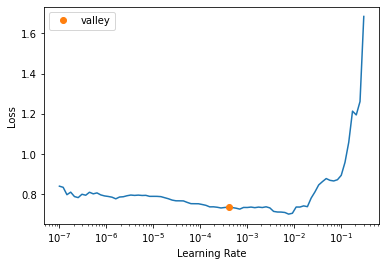

In [ ]:
tuner.lr_find()

It recommends a learning rate of around 2e-4, however a steeper slope can be found around 5e-5 so we will use that.

> Note: Reading the LR Finder is somewhat of an art. The `valley` method is one of the most reliable ones, but also try and figure out an intuition towards finding a learning rate as you go as well.

In [ ]:
lr = 5e-5

Let's look at the documentation for `tune`:

In [ ]:
show_doc(SequenceClassificationTuner.tune)

<h4 id="AdaptiveTuner.tune" class="doc_header"><code>AdaptiveTuner.tune</code><a href="https://github.com/novetta/adaptnlp/tree/master/adaptnlp/training/core.py#L375" class="source_link" style="float:right">[source]</a></h4>

> <code>AdaptiveTuner.tune</code>(**`epochs`**:`int`, **`lr`**:`float`=*`None`*, **`strategy`**:`Strategy`=*`'fit_one_cycle'`*, **`callbacks`**:`list`=*`[]`*, **\*\*`kwargs`**)

Fine tune `self.model` for `epochs` with an `lr` and `strategy`

**Parameters:**


 - **`epochs`** : *`<class 'int'>`*	<p>Number of iterations to train for</p>


 - **`lr`** : *`<class 'float'>`*, *optional*	<p>If None, finds a new learning rate and uses suggestion_method</p>


 - **`strategy`** : *`<class 'fastcore.basics.Strategy'>`*, *optional*	<p>A fitting method</p>


 - **`callbacks`** : *`<class 'list'>`*, *optional*	<p>Extra fastai Callbacks</p>


 - **`kwargs`** : *`<class 'inspect._empty'>`*


We can pass in a number of epochs, a learning rate, a strategy, and additional fastai callbacks to call.

Valid strategies live in the `Strategy` namespace class, and consist of:
- OneCycle (Also called the [One-Cycle Policy](https://docs.fast.ai/callback.schedule.html#Learner.fit_one_cycle))
- [CosineAnnealing](https://docs.fast.ai/callback.schedule.html#Learner.fit_flat_cos)
- [SGDR](https://docs.fast.ai/callback.schedule.html#Learner.fit_sgdr)

In [ ]:
from adaptnlp import Strategy

In this tutorial we will train with the One-Cycle policy, as currently it is one of the best schedulers to use.

In [ ]:
tuner.tune(3, lr, strategy=Strategy.OneCycle)

epoch,train_loss,valid_loss,accuracy,f1_score,time


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

## Saving Model

Now that we have a trained model, let's save those weights away.

Calling `tuner.save` will save both the model and the tokenizer in the same format as how HuggingFace does:

In [ ]:
show_doc(SequenceClassificationTuner.save)

In [ ]:
tuner.save('good_model')

## Performing Inference

There are two ways to get predictions, the first is with the `.predict` method in our `tuner`. This is great for if you just finished training and want to see how your model performs on some new data!
The other method is with AdaptNLP's inference API, which we will show afterwards

### In Tuner

First let's write a sentence to test with

In [ ]:
sentence = 'Amrozi accused his brother , whom he called " the witness " , of deliberately distorting his evidence . Referring to him as only " the witness " , Amrozi accused his brother of deliberately distorting his evidence .'

And then predict with it:

In [ ]:
show_doc(SequenceClassificationTuner.predict)

In [ ]:
tuner.predict(sentence)

You'll notice it says `LABEL_1`. We did not build with the `Datasets` wrapper API's, so currently they do not have a vocabulary to work off of. 

Let's pass in a vocabulary of `not_equivalent` and `equivalent` to work with:

In [ ]:
names = ['not_equivalent', 'equivalent']

In [ ]:
tuner.predict(sentence, class_names=names)

{'sentences': ['Amrozi accused his brother , whom he called " the witness " , of deliberately distorting his evidence . Referring to him as only " the witness " , Amrozi accused his brother of deliberately distorting his evidence .'],
 'predictions': ['not_equivalent'],
 'probs': tensor([[0.6317, 0.3683]])}

You can see it gave us much more readable results!

### With the Inference API

Next we will use the `EasySequenceClassifier` class, which AdaptNLP offers:

In [ ]:
from adaptnlp import EasySequenceClassifier

We simply construct the class:

In [ ]:
classifier = EasySequenceClassifier()

And call the `tag_text` method, passing in the sentence, the location of our saved model, and some names for our classes.

Similarly here, we can pass in our own vocabulary to use. Let's do that:

In [ ]:
classifier.tag_text(
    sentence,
    model_name_or_path='good_model',
    class_names=names
)

2021-08-02 19:42:29,864 loading file good_model


{'sentences': ['Amrozi accused his brother , whom he called " the witness " , of deliberately distorting his evidence . Referring to him as only " the witness " , Amrozi accused his brother of deliberately distorting his evidence .'],
 'predictions': ['not_equivalent'],
 'probs': tensor([[0.6317, 0.3683]])}

And we got the exact same output and probabilities!

There are also different levels of predictions we can return (which is also the same with our earlier `predict` call).

These live in a namespace `DetailLevel` class, with a few examples below:

In [ ]:
from adaptnlp import DetailLevel

In [ ]:
DetailLevel.Low

'low'

While some Easy modules will not return different items at each level, most will return only a few specific outputs at the Low level, and everything possible at the High level:

In [ ]:
classifier.tag_text(
    sentence,
    model_name_or_path = 'good_model',
    detail_level=DetailLevel.Low,
    class_names=names
)

{'sentences': ['Amrozi accused his brother , whom he called " the witness " , of deliberately distorting his evidence . Referring to him as only " the witness " , Amrozi accused his brother of deliberately distorting his evidence .'],
 'predictions': ['not_equivalent'],
 'probs': tensor([[0.6317, 0.3683]])}

In [ ]:
classifier.tag_text(
    sentence,
    model_name_or_path = 'good_model',
    detail_level=DetailLevel.Medium,
    class_names=names
)

{'sentences': ['Amrozi accused his brother , whom he called " the witness " , of deliberately distorting his evidence . Referring to him as only " the witness " , Amrozi accused his brother of deliberately distorting his evidence .'],
 'predictions': ['not_equivalent'],
 'probs': tensor([[0.6317, 0.3683]]),
 'pairings': OrderedDict([('Amrozi accused his brother , whom he called " the witness " , of deliberately distorting his evidence . Referring to him as only " the witness " , Amrozi accused his brother of deliberately distorting his evidence .',
               tensor([0.6317, 0.3683]))]),
 'classes': ['LABEL_0', 'LABEL_1']}

In [ ]:
classifier.tag_text(
    sentence,
    model_name_or_path = 'good_model',
    detail_level=DetailLevel.High,
    class_names=names
)

{'sentences': [Sentence: "Amrozi accused his brother , whom he called " the witness " , of deliberately distorting his evidence . Referring to him as only " the witness " , Amrozi accused his brother of deliberately distorting his evidence ."   [− Tokens: 39  − Sentence-Labels: {'sc': [LABEL_0 (0.6317), LABEL_1 (0.3683)]}]],
 'predictions': ['not_equivalent'],
 'probs': tensor([[0.6317, 0.3683]]),
 'pairings': OrderedDict([('Amrozi accused his brother , whom he called " the witness " , of deliberately distorting his evidence . Referring to him as only " the witness " , Amrozi accused his brother of deliberately distorting his evidence .',
               tensor([0.6317, 0.3683]))]),
 'classes': ['LABEL_0', 'LABEL_1']}